In [111]:
import os
import sys
sys.path.append("/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib/python3.11/site-packages")
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import mtest
from scipy.spatial.transform import Rotation as R

m = mtest.MTest()
mtest.setVerboseMode(mtest.VerboseLevel.VERBOSE_QUIET)
m.setMaximumNumberOfSubSteps(20)
m.setModellingHypothesis("Tridimensional")

model = "DruckerPragerSimple"
# model = "DruckerPrager"
# model = "DruckerPragerCap"
# model = "DruckerPragerCapOriginal"


# Set  material model implementation and path
lib_path = "/mofem_install/jupyter/thomas/mfront_interface/src/libBehaviour.so"

b = mtest.Behaviour('generic', lib_path, model,'Tridimensional')
print(b.expandInternalStateVariablesNames())
print(b.getMaterialPropertiesNames())
m.setBehaviour("generic", lib_path, model)
# in mfront:
# tan(beta) * p + q - R_DP_0 = 0
#R_DP_0 is named d in example
# FEA in geotech theory
# - M_JP * p' + J - M_JP * c' / tan(phi) = 0
# Souza
# n * p + sqrt(J2) - Xi * c = 0
# n is equal to M_JP
# Xi is M divided by tan(phi)
# q = sqrt(3J2)
# phi is the internal friction angle
E = 150
nu = 0.499
phi = np.radians(35)
v = np.radians(10)
c = 30
# fitting at triaxial compression: lode angle = -30
M_JP = 2 * np.sqrt(3) * np.sin(phi) / (3 -  np.sin(phi))

# Loading programme
tMax = 1.0  # s , total time
nTime = 2000
ltime = np.linspace(0.0, tMax, nTime)
# Environment parameters
m.setExternalStateVariable("Temperature", 293.15)

# Material parameters
m.setMaterialProperty("YoungModulus", E)
m.setMaterialProperty("PoissonRatio", nu)
if model == "DruckerPragerSimple":
    m.setMaterialProperty("phi", phi)
    m.setMaterialProperty("c", c)
elif model == "DruckerPrager":
    m.setMaterialProperty("phi", phi)
    m.setMaterialProperty("c", c)
    m.setMaterialProperty("v", v)
elif model == "DruckerPragerCap":
    beta = np.arctan(M_JP * np.sqrt(3))
    d = M_JP * c / np.tan(phi)
    m.setMaterialProperty("beta", beta)
    m.setMaterialProperty("d", d)
    m.setMaterialProperty("pa", 300)
    m.setMaterialProperty("pb", 500)
elif model == "DruckerPragerCapOriginal":
    m.setMaterialProperty("beta", beta)
    m.setMaterialProperty("d", d)
    m.setMaterialProperty("pa", -300)
    m.setMaterialProperty("pb", -500)
else:
    raise NotImplementedError()

controls = ["stress", "strain"]
control = controls[1]
if control == "stress":
    p_con_0 =  0 # confining pressure
    p_con_1 =  0 # confining pressure
    p_axi_0 = 0
    p_axi_1 = 130
    if model == 'DruckerPragerCapOriginal':
        p_con_0 =  -0 # confining pressure
        p_con_1 =  -0 # confining pressure
        p_axi_0 = -0
        p_axi_1 = -60
    m.setImposedStress("SXX", {0: p_con_0, 0.02: p_con_0, 1.0: p_con_1})
    m.setImposedStress("SYY", {0: p_con_0, 0.02: p_con_0, 1.0: p_con_1})
    m.setImposedStress("SZZ", {0: p_axi_0, 0.02: p_axi_0, 1.0: p_axi_1})
if control == "strain":
    # Set imposed strains for axial and confining directions
    # m.setImposedStrain("EXX", {0: 0, 1.0: 0.00001})
    # m.setImposedStrain("EYY", {0: 0, 1.0: 0.00001})
    m.setImposedStrain("EZZ", {0: 0, 1.0: 2})


s = mtest.MTestCurrentState()
wk = mtest.MTestWorkSpace()
m.completeInitialisation()
m.initializeCurrentState(s)
m.initializeWorkSpace(wk)

# initialize output lists
sig_xx = []
sig_yy = []
sig_zz = []
sig_xy = []
sig_xz = []
sig_yz = []
sig_e_eq_trial = []
e_xx = []
e_yy = []
e_zz = []
e_xy = []
e_xz = []
e_yz = []

e_e_xx = []
e_e_yy = []
e_e_zz = []
e_e_xy = []
e_e_xz = []
e_e_yz = []

test = []
ok = True
if ok:
    e_p_xx = []
    e_p_yy = []
    e_p_zz = []
    e_p_xy = []
    e_p_xz = []
    e_p_yz = []
e_p_eq = []
# run sim
for i in range(nTime - 1):
    # print(f"===========Loop {i}===========")
    try:
        m.execute(s, wk, ltime[i], ltime[i + 1])
    except Exception as e:
        break
    sig_xx.append(s.s1[0])
    sig_yy.append(s.s1[1])
    sig_zz.append(s.s1[2])
    sig_xy.append(s.s1[3])
    sig_xz.append(s.s1[4])
    sig_yz.append(s.s1[5])
    
    eel = s.getInternalStateVariableValue("ElasticStrain")
    if ok:
        epl = s.getInternalStateVariableValue("PlasticStrain")
    if model == "DruckerPragerSimple" or model == "DruckerPrager":
        epleq = s.getInternalStateVariableValue("EquivalentPlasticStrain")
        t = s.getInternalStateVariableValue("test")
    else:
        epleq = s.getInternalStateVariableValue("EquivalentPlasticStrain[0]")
    sig_e_eq_trial.append(s.getInternalStateVariableValue("TrialEquivalentStress"))
    if model == 'DruckerPragerCapOriginal':
        e_xx.append(-s.e1[0])
        e_yy.append(-s.e1[1])
        e_zz.append(-s.e1[2])
        e_xy.append(-s.e1[3])
        e_xz.append(-s.e1[4])
        e_yz.append(-s.e1[5])
        
        e_e_xx.append(-eel[0])
        e_e_yy.append(-eel[1])
        e_e_zz.append(-eel[2])
        e_e_xy.append(-eel[3])
        e_e_xz.append(-eel[4])
        e_e_yz.append(-eel[5])
    else:
        e_xx.append(s.e1[0])
        e_yy.append(s.e1[1])
        e_zz.append(s.e1[2])
        e_xy.append(s.e1[3])
        e_xz.append(s.e1[4])
        e_yz.append(s.e1[5])
        
        e_e_xx.append(eel[0])
        e_e_yy.append(eel[1])
        e_e_zz.append(eel[2])
        e_e_xy.append(eel[3])
        e_e_xz.append(eel[4])
        e_e_yz.append(eel[5])
    if ok:
        e_p_xx.append(epl[0])
        e_p_yy.append(epl[1])
        e_p_zz.append(epl[2])
        e_p_xy.append(epl[3])
        e_p_xz.append(epl[4])
        e_p_yz.append(epl[5])
    
    e_p_eq.append(epleq)
    test.append(t)

test = np.array(test)
sig_xx = np.array(sig_xx)   
sig_yy = np.array(sig_yy)   
sig_zz = np.array(sig_zz)   
sig_xy = np.array(sig_xy)   
sig_xz = np.array(sig_xz)   
sig_yz = np.array(sig_yz)
sig_e_eq_trial = np.array(sig_e_eq_trial)   
e_xx = np.array(e_xx)   
e_yy = np.array(e_yy)   
e_zz = np.array(e_zz)   
e_xy = np.array(e_xy)   
e_xz = np.array(e_xz)   
e_yz = np.array(e_yz)  
e_e_xx = np.array(e_e_xx)   
e_e_yy = np.array(e_e_yy)   
e_e_zz = np.array(e_e_zz)   
e_e_xy = np.array(e_e_xy)   
e_e_xz = np.array(e_e_xz)   
e_e_yz = np.array(e_e_yz)  
if ok:
    e_p_xx = np.array(e_p_xx)   
    e_p_yy = np.array(e_p_yy)   
    e_p_zz = np.array(e_p_zz)   
    e_p_xy = np.array(e_p_xy)   
    e_p_xz = np.array(e_p_xz)   
    e_p_yz = np.array(e_p_yz)  
    e_p_eq = np.array(e_p_eq)  

print("===========")
print(f"Triaxial test: Tridimensional")
# print(e_xx[-1])
# result_dir = f"/mofem_install/jupyter/thomas/mfront_interface/results/DP_sig_1_{p_axi_1}/"
# os.makedirs(result_dir,exist_ok=True)

['ElasticStrainXX', 'ElasticStrainYY', 'ElasticStrainZZ', 'ElasticStrainXY', 'ElasticStrainXZ', 'ElasticStrainYZ', 'EquivalentPlasticStrain', 'TrialEquivalentStress', 'PlasticStrainXX', 'PlasticStrainYY', 'PlasticStrainZZ', 'PlasticStrainXY', 'PlasticStrainXZ', 'PlasticStrainYZ', 'test']
['phi', 'c', 'YoungModulus', 'PoissonRatio']
Triaxial test: Tridimensional


In [112]:

# Function to calculate principal stresses and directions
def calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz):
    sig_1 = []
    sig_2 = []
    sig_3 = []

    for i in range(len(sig_xx)):
        # Create stress tensor
        stress_tensor = np.array([
            [sig_xx[i], sig_xy[i], sig_xz[i]],
            [sig_xy[i], sig_yy[i], sig_yz[i]],
            [sig_xz[i], sig_yz[i], sig_zz[i]]
        ])

        # Calculate principal stresses (eigenvalues)
        principal_stresses, _ = np.linalg.eigh(stress_tensor)
        principal_stresses = np.sort(principal_stresses)[::-1]  # Sort in descending order

        # Append principal stresses to respective lists
        sig_1.append(principal_stresses[0])
        sig_2.append(principal_stresses[1])
        sig_3.append(principal_stresses[2])

    # Convert lists to numpy arrays
    sig_1 = np.array(sig_1)
    sig_2 = np.array(sig_2)
    sig_3 = np.array(sig_3)

    return sig_1, sig_2, sig_3

def p(sig_1, sig_2, sig_3):
    return (sig_1 + sig_2 + sig_3) / 3

# Function to calculate J2 invariant
def calculate_J2(sig_1, sig_2, sig_3):
    J2_list = (1/6) * ((sig_1 - sig_2) ** 2 + (sig_2 - sig_3) ** 2 + (sig_3 - sig_1) ** 2)
    
    return J2_list

# Function to calculate volumetric strain and deviatoric strain
def calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz):
    volumetric_strain_list = []
    deviatoric_strain_list = []

    for i in range(len(e_xx)):
        # Volumetric strain is the trace of the strain tensor
        volumetric_strain = e_xx[i] + e_yy[i] + e_zz[i]
        volumetric_strain_list.append(volumetric_strain)

        # Deviatoric strain components
        e_mean = volumetric_strain / 3
        e_dev_xx = e_xx[i] - e_mean
        e_dev_yy = e_yy[i] - e_mean
        e_dev_zz = e_zz[i] - e_mean
        e_dev_xy = e_xy[i]
        e_dev_xz = e_xz[i]
        e_dev_yz = e_yz[i]

        # Deviatoric strain magnitude
        deviatoric_strain = np.sqrt(2/3 * (e_dev_xx**2 + e_dev_yy**2 + e_dev_zz**2) + 2 * (e_dev_xy**2 + e_dev_xz**2 + e_dev_yz**2))
        deviatoric_strain_list.append(deviatoric_strain)

    volumetric_strain_list = np.array(volumetric_strain_list)
    deviatoric_strain_list = np.array(deviatoric_strain_list)
    return volumetric_strain_list, deviatoric_strain_list

def calculate_equivalent_plastic_strain(e_p_xx, e_p_yy, e_p_zz, e_p_xy, e_p_xz, e_p_yz):
    """
    Calculate the equivalent plastic strain from the components of plastic strain.

    Parameters:
    e_p_xx, e_p_yy, e_p_zz, e_p_xy, e_p_xz, e_p_yz : array-like
        Arrays of the plastic strain components.

    Returns:
    e_p_eq : array-like
        Equivalent plastic strain.
    """
    # Convert inputs to numpy arrays
    e_p_xx = np.array(e_p_xx)
    e_p_yy = np.array(e_p_yy)
    e_p_zz = np.array(e_p_zz)
    e_p_xy = np.array(e_p_xy)
    e_p_xz = np.array(e_p_xz)
    e_p_yz = np.array(e_p_yz)

    # Calculate the equivalent plastic strain using the von Mises criterion
    e_p_eq = np.sqrt(
        (2/3) * (
            (e_p_xx - e_p_yy)**2 + (e_p_yy - e_p_zz)**2 + (e_p_zz - e_p_xx)**2 +
            6 * (e_p_xy**2 + e_p_xz**2 + e_p_yz**2)
        ) / 2
    )

    return e_p_eq

sig_1, sig_2, sig_3 = calculate_principal_stresses(sig_xx, sig_yy, sig_zz, sig_xy, sig_xz, sig_yz)

p = p(sig_1, sig_2, sig_3)
J_2 = calculate_J2(sig_1, sig_2, sig_3)
J = np.sqrt(J_2)
tau_oct = np.sqrt(2 * J_2)
sig_eq = np.sqrt(3 * J_2)

# from propoerties
# sqrt(2) * J
cone_radius = np.sqrt(2) *  (c / np.tan(phi) + p) * M_JP

cone_tip_p = - c / np.tan(phi)
e_v, e_d = calculate_volumetric_and_deviatoric_strain(e_xx, e_yy, e_zz, e_xy, e_xz, e_yz)
e_e_v, e_e_d = calculate_volumetric_and_deviatoric_strain(e_e_xx, e_e_yy, e_e_zz, e_e_xy, e_e_xz, e_e_yz)
if ok:
    e_p_v, e_p_d = calculate_volumetric_and_deviatoric_strain(e_p_xx, e_p_yy, e_p_zz, e_p_xy, e_p_xz, e_p_yz)
    e_p_eq_calc = calculate_equivalent_plastic_strain(e_p_xx, e_p_yy, e_p_zz, e_p_xy, e_p_xz, e_p_yz)

In [113]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import os

# def init_axes():
#     # Create a figure and 3D axis
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     return fig, ax

# def plot_cone_and_points(ax, radius, start_height=-50, end_height=100):
#     # Step 1: Define the direction vector of the space diagonal
#     diagonal_direction = np.array([1, 1, 1]) / np.linalg.norm([1, 1, 1])

#     # Step 2: Generate the cone along the direction of the space diagonal
#     height = np.linspace(0, end_height - start_height, 50)
#     angle = np.linspace(0, 2 * np.pi, 100)
#     Height, Angle = np.meshgrid(height, angle)

#     # Define two orthogonal vectors that are perpendicular to the diagonal direction
#     orthogonal_vector_1 = np.array([1.0, -1.0, 0.0])
#     orthogonal_vector_1 /= np.linalg.norm(orthogonal_vector_1)
#     orthogonal_vector_2 = np.cross(diagonal_direction, orthogonal_vector_1)

#     # Compute the radius of the cone at each height (linearly increases from zero)
#     cone_radius = radius * (Height / (end_height - start_height))

#     # Compute the coordinates of the cone
#     X = (cone_radius * np.cos(Angle) * orthogonal_vector_1[0] +
#          cone_radius * np.sin(Angle) * orthogonal_vector_2[0] +
#          (Height + start_height) * diagonal_direction[0])
#     Y = (cone_radius * np.cos(Angle) * orthogonal_vector_1[1] +
#          cone_radius * np.sin(Angle) * orthogonal_vector_2[1] +
#          (Height + start_height) * diagonal_direction[1])
#     Z = (cone_radius * np.cos(Angle) * orthogonal_vector_1[2] +
#          cone_radius * np.sin(Angle) * orthogonal_vector_2[2] +
#          (Height + start_height) * diagonal_direction[2])

#     # Step 3: Plot the cone
#     ax.plot_surface(X, Y, Z, alpha=0.5, color='m')

#     # Step 4: Set the base of the cone for the circle at the end height
#     base_point = end_height * diagonal_direction

#     # Step 5: Plot a circle around the base point to indicate it lies on the cone plane
#     circle_angle = np.linspace(0, 2 * np.pi, 100)
#     cone_radius_at_base = radius
#     circle_x = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[0] +
#                 cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[0] +
#                 base_point[0])
#     circle_y = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[1] +
#                 cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[1] +
#                 base_point[1])
#     circle_z = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[2] +
#                 cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[2] +
#                 base_point[2])
#     ax.plot(circle_x, circle_y, circle_z, color='b')
#     ax.scatter(*base_point, color='b', s=100)

#     # Step 6: Define a plane that cuts through the cone at the base height
#     plane_normal = diagonal_direction
#     plane_point = base_point  # Plane passes through the base point

#     # Step 7: Find intersection points of the plane with the cone
#     cone_points = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
#     plane_distances = np.dot(cone_points - plane_point, plane_normal)
#     intersection_indices = np.where(np.abs(plane_distances) < 0.05)[0]
#     intersection_points = cone_points[intersection_indices]

#     # Step 8: Pick three random points from the intersection points
#     if intersection_points.shape[0] >= 3:
#         random_indices = np.random.choice(intersection_points.shape[0], 3, replace=False)
#         random_points = intersection_points[random_indices]
#         # Plot the three random points and lines connecting them to the base point
#         for i in range(3):
#             ax.scatter(random_points[i, 0], random_points[i, 1], random_points[i, 2], color='g', s=50)
#             ax.plot([base_point[0], random_points[i, 0]],
#                     [base_point[1], random_points[i, 1]],
#                     [base_point[2], random_points[i, 2]], color='k', linestyle='--')
#             distance = np.linalg.norm(random_points[i] - base_point)
#             print(f"Distance from base point to point {i+1}: {distance:.2f}")
#     else:
#         print("Not enough intersection points found to select three random points.")

# def plot_stress_history(ax, sig_1, sig_2, sig_3):
#     # Plot stress history
    
#     ax.scatter(sig_1, sig_2, sig_3, color='b')
    
#     # Plot volumetric stress line along the space diagonal
#     vol_stress_value = (sig_1 + sig_2 + sig_3) / 3
#     diagonal_direction = np.array([1, 1, 1]) / np.linalg.norm([1, 1, 1])

#     # Calculate volumetric stress components
#     vol_stress_x = vol_stress_value * diagonal_direction[0]
#     vol_stress_y = vol_stress_value * diagonal_direction[1]
#     vol_stress_z = vol_stress_value * diagonal_direction[2]
#     ax.scatter(vol_stress_x,vol_stress_y,vol_stress_z, color='r', linestyle='-', label='Volumetric Stress')
    
#     # Plot deviatoric stress line from the space diagonal to the final stress state
#     ax.plot([vol_stress_x[-1], sig_1[-1]], [vol_stress_y[-1], sig_2[-1]], [vol_stress_z[-1], sig_3[-1]], color='g', linestyle='-', label='Deviatoric Stress')

    
# def plot_meta(ax):
#     # Set labels
#     ax.set_xlabel(r'$\sigma_1$')
#     ax.set_ylabel(r'$\sigma_2$')
#     ax.set_zlabel(r'$\sigma_3$')
#     ax.set_title('3D Plot of Principal Stresses')
    
#     # Add x, y, and z planes at zero
#     ax.plot([0, 0], ax.get_ylim(), [0, 0], color='k', linestyle='--', alpha=0.5)  # y-plane
#     ax.plot(ax.get_xlim(), [0, 0], [0, 0], color='k', linestyle='--', alpha=0.5)  # x-plane
#     ax.plot([0, 0], [0, 0], ax.get_zlim(), color='k', linestyle='--', alpha=0.5)  # z-plane
#     # Set equal aspect ratio
#     limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
#     ax.set_box_aspect(np.ptp(limits, axis = 1))
    
#     ax.view_init(elev=45, azim=45)

# def plot_stress_field():
#     # Calculate principal stresses and directions

#     # Initialize the axes
#     fig, ax = init_axes()

#     # Plot the cylinder and related points
#     plot_cone_and_points(ax, radius=cone_base_radius, start_height = cone_tip_p, end_height=p[-1])
#     plot_stress_history(ax, sig_1, sig_2, sig_3)
#     plot_meta(ax)
#     plt.show()
    
# # Function to plot J2 invariant against axial strain e_zz
# def plot_J_vs_axial_strain(J, e_zz):
#     plt.figure()
#     plt.plot(e_zz, J, marker='o', linestyle='-', color='b')
#     plt.xlabel('Axial Strain ($\epsilon_{zz}$)')
#     plt.ylabel('Deviatoric Stress J')
#     plt.title('J - Axial Strain')
#     plt.grid(True)
#     plt.show()

# def plot_tau_vs_e_zz(tau, e_zz):
#     plt.figure()
#     plt.plot(e_zz, tau, marker='o', linestyle='-', color='b')
#     plt.xlabel('Axial Strain ($\epsilon_{zz}$)')
#     plt.ylabel('Shear Stress ($\\tau $)')
#     plt.title('$\\tau $ - Axial Strain')
#     plt.grid(True)
#     plt.show()

   
# def plot_sig_eq_vs_e_zz(sig_eq, e_zz):
#     plt.figure()
#     plt.plot(e_zz, sig_eq, marker='o', linestyle='-', color='b')
#     # plt.plot(e_zz, sig_e_eq_trial, marker='o', linestyle='-', color='r')
#     plt.xlabel('Axial Strain ($\epsilon_{zz}$)')
#     plt.ylabel('Equivalent Stress ($\sigma_{eq}$)')
#     plt.title('$\sigma_{eq}$ - Axial Strain')
#     plt.grid(True)
#     plt.show()

# # Function to plot volumetric strain against axial strain e_zz
# def plot_volumetric_strain_vs_axial_strain(volumetric_strain_list, e_zz):
#     plt.figure()
#     plt.plot(e_zz, volumetric_strain_list, marker='o', linestyle='-', color='g')
#     plt.xlabel('Axial Strain ($\epsilon_{zz}$)')
#     plt.ylabel('Volumetric Strain ($\epsilon_v$)')
#     plt.title('Volumetric Strain vs Axial Strain')
#     plt.grid(True)
#     plt.show()
    
# # Function to plot volumetric strain against deviatoric strain 
# def plot_volumetric_strain_vs_deviatoric_strain(ax, e_v, e_d):
#     # Plot the primary strain data
#     ax.plot(e_d, e_v, marker='o', linestyle='-', color='g', label='total strain')

#     # Optional plot for elastic deviatoric and volumetric strain (if provided)
#     if e_e_d is not None and e_e_v is not None:
#         ax.plot(e_e_d, e_e_v, marker='o', linestyle='-', color='b', label='elastic strain')

#     # Optional plot for plastic deviatoric and volumetric strain if `ok` is True
#     if ok and e_p_d is not None and e_p_v is not None:
#         ax.plot(e_p_d, e_p_v, marker='o', linestyle='-', color='r', label='plastic strain')

#     # Set labels, title, grid, and legend
#     ax.set_xlabel('Deviatoric Strain ($\\epsilon_d$)')
#     ax.set_ylabel('Volumetric Strain ($\\epsilon_v$)')
#     ax.set_title('Volumetric Strain vs Deviatoric Strain')
#     ax.grid(True)
#     ax.legend()
#     plt.show()
    
# # jus testing 
# def plot_e_p_eq_vs_e_zz(e_p_eq, e_zz):
#     plt.figure()
#     plt.plot(e_zz, e_p_eq, marker='o', linestyle='-', color='g')
#     if ok:
#         plt.plot(e_zz, e_p_eq_calc, marker='o', linestyle='-', color='b')
    
#     plt.xlabel('Axial Strain ($e_{zz}$)')
#     plt.ylabel('Equivalent Plastsic Strain ($e^p_{eq}$)')
#     plt.title('Equivalent Plastic Strain vs Axial Strain')
#     plt.grid(True)
#     plt.show()
    
# def testing(J, test):
#     plt.figure()
#     plt.plot(J, test, marker='o', linestyle='-', color='b')
#     plt.grid(True)
#     plt.show()
    
# plot_stress_field()
# # plot_J_vs_axial_strain(J, e_zz)
# plot_tau_vs_e_zz(tau, e_zz)
# plot_sig_eq_vs_e_zz(sig_eq, e_zz)
# plot_volumetric_strain_vs_axial_strain(e_v, e_zz)
# fig, ax = plt.subplots()
# plot_volumetric_strain_vs_deviatoric_strain(ax, e_v, e_d)
# plot_e_p_eq_vs_e_zz(e_p_eq, e_zz)
# testing(sig_eq, test)
    

[ 0.          1.92058205  3.84116409  5.76174614  7.68232819  9.60291024
 11.52349228 13.44407433 15.36465638 17.28523843 19.20582047 21.12640252
 23.04698457 24.96756662 26.88814866 28.80873071 30.72931276 32.64989481
 34.57047685 36.4910589  38.41164095 40.332223   42.25280504 44.17338709
 46.09396914 48.01455118 49.93513323 51.85571528 53.77629733 55.69687937
 57.61746142 59.53804347 61.45862552 63.37920756 65.29978961 67.22037166
 69.14095371 71.06153575 72.9821178  74.90269985 76.8232819  78.74386394
 80.66444599 82.58502804 84.50561008 86.42619213 88.34677418 90.26735623
 92.18793827 94.10852032]
Distance from base point to point 1: 94.11
Distance from base point to point 2: 94.11
Distance from base point to point 3: 94.11
[ 0.          1.92058205  3.84116409  5.76174614  7.68232819  9.60291024
 11.52349228 13.44407433 15.36465638 17.28523843 19.20582047 21.12640252
 23.04698457 24.96756662 26.88814866 28.80873071 30.72931276 32.64989481
 34.57047685 36.4910589  38.41164095 40.33

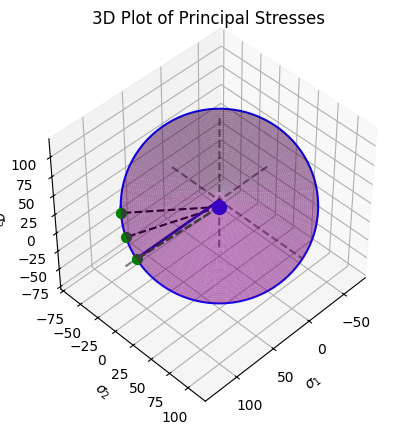

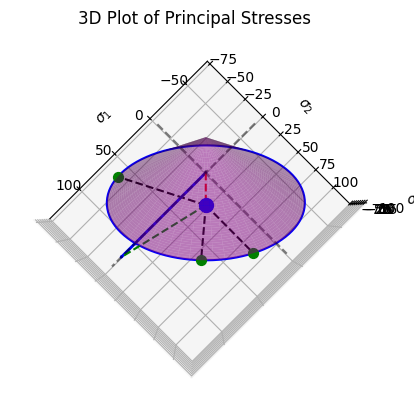

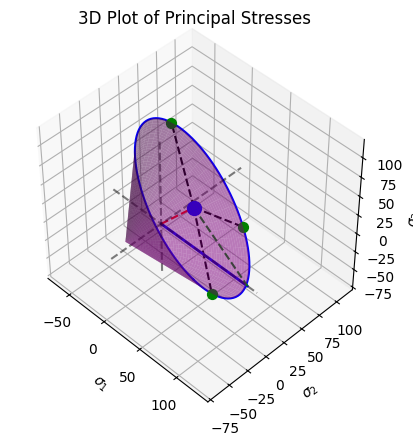

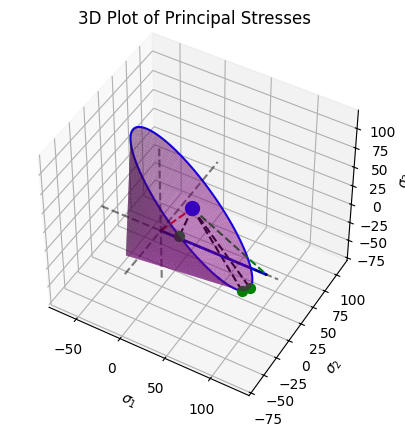

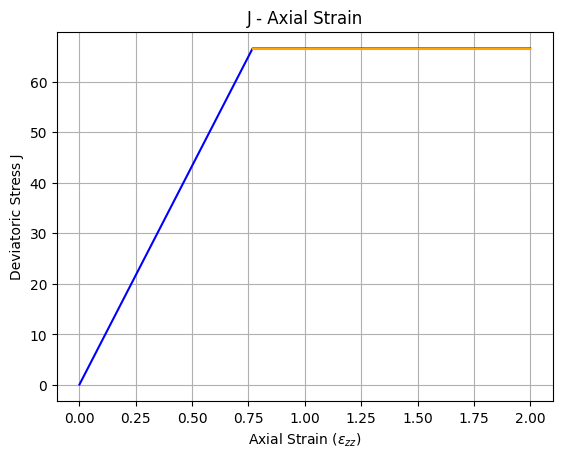

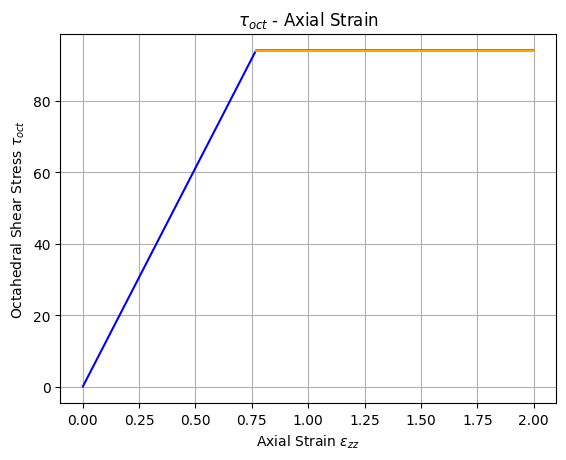

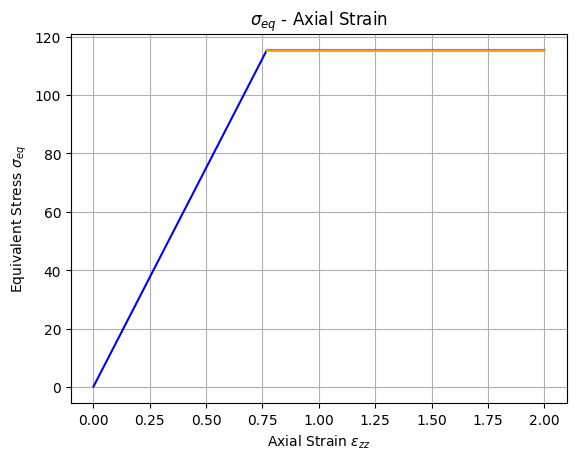

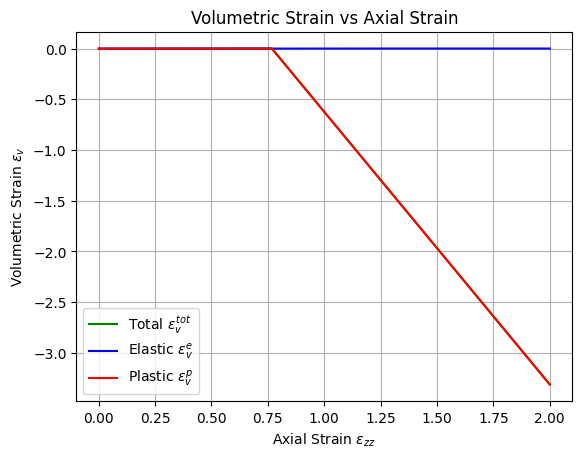

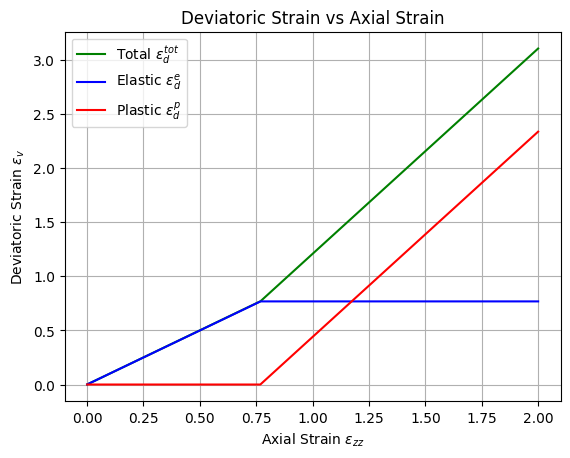

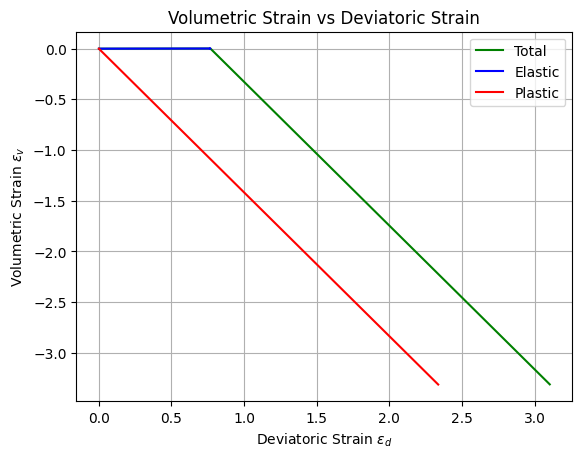

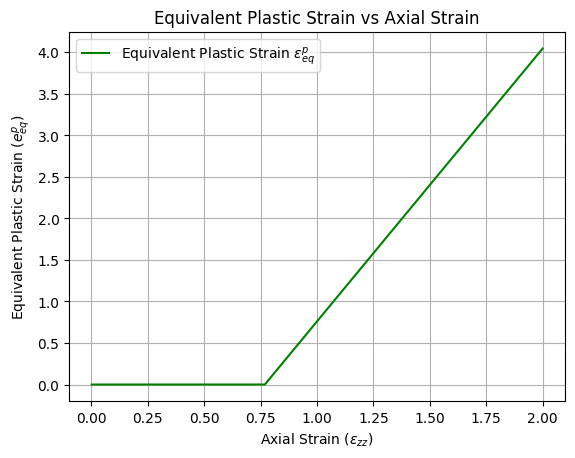

In [114]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

PLOT_DIR = f"/mofem_install/jupyter/thomas/mfront_interface/mtest_plots/{model}"
os.makedirs(PLOT_DIR, exist_ok=True)


# Initialize axes for 3D plotting
def init_axes():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    return fig, ax

def plot_cone_and_points(ax, radius, start_height=-50, end_height=100):
    # Step 1: Define the direction vector of the space diagonal
    diagonal_direction = np.array([1, 1, 1]) / np.linalg.norm([1, 1, 1])

    # Step 2: Generate the cone along the direction of the space diagonal
    height = np.linspace(0, end_height - start_height, 50)
    angle = np.linspace(0, 2 * np.pi, 100)
    Height, Angle = np.meshgrid(height, angle)

    # Define two orthogonal vectors that are perpendicular to the diagonal direction
    orthogonal_vector_1 = np.array([1.0, -1.0, 0.0])
    orthogonal_vector_1 /= np.linalg.norm(orthogonal_vector_1)
    orthogonal_vector_2 = np.cross(diagonal_direction, orthogonal_vector_1)

    # Compute the radius of the cone at each height (linearly increases from zero)
    cone_radius = radius * (Height / (end_height - start_height))
    print(cone_radius[-1])
    # Compute the coordinates of the cone
    X = (cone_radius * np.cos(Angle) * orthogonal_vector_1[0] +
         cone_radius * np.sin(Angle) * orthogonal_vector_2[0] +
         (Height + start_height) * diagonal_direction[0])
    Y = (cone_radius * np.cos(Angle) * orthogonal_vector_1[1] +
         cone_radius * np.sin(Angle) * orthogonal_vector_2[1] +
         (Height + start_height) * diagonal_direction[1])
    Z = (cone_radius * np.cos(Angle) * orthogonal_vector_1[2] +
         cone_radius * np.sin(Angle) * orthogonal_vector_2[2] +
         (Height + start_height) * diagonal_direction[2])

    # Step 3: Plot the cone
    ax.plot_surface(X, Y, Z, alpha=0.5, color='m')

    # Step 4: Set the base of the cone for the circle at the end height
    base_point = end_height * diagonal_direction

    # Step 5: Plot a circle around the base point to indicate it lies on the cone plane
    circle_angle = np.linspace(0, 2 * np.pi, 100)
    cone_radius_at_base = radius
    circle_x = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[0] +
                cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[0] +
                base_point[0])
    circle_y = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[1] +
                cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[1] +
                base_point[1])
    circle_z = (cone_radius_at_base * np.cos(circle_angle) * orthogonal_vector_1[2] +
                cone_radius_at_base * np.sin(circle_angle) * orthogonal_vector_2[2] +
                base_point[2])
    ax.plot(circle_x, circle_y, circle_z, color='b')
    ax.scatter(*base_point, color='b', s=100)

    # Step 6: Define a plane that cuts through the cone at the base height
    plane_normal = diagonal_direction
    plane_point = base_point  # Plane passes through the base point

    # Step 7: Find intersection points of the plane with the cone
    cone_points = np.vstack((X.flatten(), Y.flatten(), Z.flatten())).T
    plane_distances = np.dot(cone_points - plane_point, plane_normal)
    intersection_indices = np.where(np.abs(plane_distances) < 0.05)[0]
    intersection_points = cone_points[intersection_indices]

    # Step 8: Pick three random points from the intersection points
    if intersection_points.shape[0] >= 3:
        random_indices = np.random.choice(intersection_points.shape[0], 3, replace=False)
        random_points = intersection_points[random_indices]
        # Plot the three random points and lines connecting them to the base point
        for i in range(3):
            ax.scatter(random_points[i, 0], random_points[i, 1], random_points[i, 2], color='g', s=50)
            ax.plot([base_point[0], random_points[i, 0]],
                    [base_point[1], random_points[i, 1]],
                    [base_point[2], random_points[i, 2]], color='k', linestyle='--')
            distance = np.linalg.norm(random_points[i] - base_point)
            print(f"Distance from base point to point {i+1}: {distance:.2f}")
    else:
        print("Not enough intersection points found to select three random points.")
        
# Plot stress history with classification based on tau_oct
def plot_stress_history(ax, sig_1, sig_2, sig_3, tau_oct, tau_oct_limit, save_as: str =None):
    
    mask_elastic = tau_oct < tau_oct_limit
    mask_plastic = tau_oct >= tau_oct_limit
    if np.any(mask_elastic):
        ax.plot(sig_1[mask_elastic], sig_2[mask_elastic], sig_3[mask_elastic], color='b', label='Elastic', linewidth=2)
    if np.any(mask_plastic):
        ax.plot(sig_1[mask_plastic], sig_2[mask_plastic], sig_3[mask_plastic], color='orange', label='Plastic', linewidth=2)

    vol_stress_value = (sig_1 + sig_2 + sig_3) / 3
    diagonal_direction = np.array([1, 1, 1]) / np.linalg.norm([1, 1, 1])
    vol_stress_x = vol_stress_value * diagonal_direction[0]
    vol_stress_y = vol_stress_value * diagonal_direction[1]
    vol_stress_z = vol_stress_value * diagonal_direction[2]
    ax.plot(vol_stress_x, vol_stress_y, vol_stress_z, color='r', linestyle='--', label='Volumetric Stress')
    ax.plot([vol_stress_x[-1], sig_1[-1]], [vol_stress_y[-1], sig_2[-1]], [vol_stress_z[-1], sig_3[-1]], color='g', linestyle='--', label='Deviatoric Stress')

# Plot metadata like labels and planes
def plot_meta(ax, elev, azim):
    ax.set_xlabel(r'$\sigma_1$')
    ax.set_ylabel(r'$\sigma_2$')
    ax.set_zlabel(r'$\sigma_3$')
    ax.set_title('3D Plot of Principal Stresses')

    ax.plot([0, 0], ax.get_ylim(), [0, 0], color='k', linestyle='--', alpha=0.5)  # y-plane
    ax.plot(ax.get_xlim(), [0, 0], [0, 0], color='k', linestyle='--', alpha=0.5)  # x-plane
    ax.plot([0, 0], [0, 0], ax.get_zlim(), color='k', linestyle='--', alpha=0.5)  # z-plane
    limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
    ax.set_box_aspect(np.ptp(limits, axis=1))
    ax.view_init(elev=elev, azim=azim)

# General plotting function for 2D plots
def plot_2d(x, y, xlabel, ylabel, title, color='b', linestyle='-', label=None, plastic_cutoff=None, save_as: str = None):
    plt.figure()
    if plastic_cutoff:
        mask_elastic = y < plastic_cutoff
        mask_plastic = y >= plastic_cutoff
        plt.plot(x[mask_elastic], y[mask_elastic], linestyle=linestyle, color='b', label=label)
        plt.plot(x[mask_plastic], y[mask_plastic], linestyle=linestyle, color='orange', label=label)
    else:
        plt.plot(x, y, linestyle=linestyle, color=color, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    if label:
        plt.legend()
    
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath

# Plot functions for specific variables
def plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p, final_p, elev, azim, save_as: str =None):
    fig, ax = init_axes()
    plot_cone_and_points(ax, radius=cone_radius[-1], start_height = cone_tip_p, end_height=final_p)
    plot_stress_history(ax, sig_1, sig_2, sig_3, tau_oct, cone_radius)
    plot_meta(ax, elev, azim)
    
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath


def plot_J_vs_axial_strain(J, e_zz, save_as: str =None):
    # J = sqrt(J2)
    # cutoff = sig_y/sqrt(3)
    return plot_2d(e_zz, J, 'Axial Strain ($\epsilon_{zz}$)', 'Deviatoric Stress J', 'J - Axial Strain', plastic_cutoff= (c / np.tan(phi) + p[-1]) * M_JP, save_as=save_as)

def plot_tau_vs_e_zz(tau_oct, e_zz, save_as: str =None):
    return plot_2d(e_zz, tau_oct, 'Axial Strain $\epsilon_{zz}$', 'Octahedral Shear Stress $\\tau_{oct}$', '$\\tau_{oct}$ - Axial Strain', plastic_cutoff= np.sqrt(2) *  (c / np.tan(phi) + p[-1]) * M_JP, save_as=save_as)

def plot_sig_eq_vs_e_zz(sig_eq, e_zz, save_as: str =None):
    return plot_2d(e_zz, sig_eq, 'Axial Strain $\epsilon_{zz}$', 'Equivalent Stress $\sigma_{eq}$', '$\sigma_{eq}$ - Axial Strain', plastic_cutoff= np.sqrt(3) *  (c / np.tan(phi) + p[-1]) * M_JP,save_as=save_as)

def plot_volumetric_strain_vs_axial_strain(e_zz, e_v=None, e_e_v=None, e_p_v=None, save_as: str =None):
    plt.figure()
    # elastic and total coincide, which means there is zero volumetric plastic strain
    plt.plot(e_zz, e_v, linestyle='-', color='g', label='Total $\epsilon^{tot}_v$')
    plt.plot(e_zz, e_e_v, linestyle='-', color='b', label='Elastic $\epsilon^e_v$')
    plt.plot(e_zz, e_p_v, linestyle='-', color='r', label='Plastic $\epsilon^p_v$')
    plt.xlabel('Axial Strain $\epsilon_{zz}$')
    plt.ylabel('Volumetric Strain $\epsilon_v$')
    plt.title('Volumetric Strain vs Axial Strain')
    plt.grid(True)
    plt.legend()
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath
    
def plot_deviatoric_strain_vs_axial_strain(e_zz, e_d=None, e_e_d=None, e_p_d=None, save_as: str =None):
    plt.figure()
    # elastic and total coincide, which means there is zero volumetric plastic strain
    plt.plot(e_zz, e_d, linestyle='-', color='g', label='Total $\epsilon^{tot}_d$')
    plt.plot(e_zz, e_e_d, linestyle='-', color='b', label='Elastic $\epsilon^e_d$')
    plt.plot(e_zz, e_p_d, linestyle='-', color='r', label='Plastic $\epsilon^p_d$')
    plt.xlabel('Axial Strain $\epsilon_{zz}$')
    plt.ylabel('Deviatoric Strain $\epsilon_v$')
    plt.title('Deviatoric Strain vs Axial Strain')
    plt.grid(True)
    plt.legend()
    
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath

def plot_volumetric_strain_vs_deviatoric_strain(e_v, e_d, e_e_d=None, e_e_v=None, e_p_d=None, e_p_v=None, ok=False, save_as: str =None):
    plt.figure()
    plt.plot(e_d, e_v, linestyle='-', color='g', label='Total')
    if e_e_d is not None and e_e_v is not None:
        plt.plot(e_e_d, e_e_v, linestyle='-', color='b', label='Elastic')
    if e_p_d is not None and e_p_v is not None:
        plt.plot(e_p_d, e_p_v, linestyle='-', color='r', label='Plastic')
    plt.xlabel('Deviatoric Strain $\epsilon_d$')
    plt.ylabel('Volumetric Strain $\epsilon_v$')
    plt.title('Volumetric Strain vs Deviatoric Strain')
    plt.grid(True)
    plt.legend()
    
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath

def plot_e_p_eq_vs_e_zz(e_p_eq, e_zz, e_p_eq_calc=None, ok=False, save_as: str =None):
    plt.figure()
    plt.plot(e_zz, e_p_eq, linestyle='-', color='g', label='Equivalent Plastic Strain $\epsilon^p_{eq}$')
    if ok and e_p_eq_calc is not None:
        plt.plot(e_zz, e_p_eq_calc, linestyle='-', color='b', label='Calculated Plastic Strain')
    plt.xlabel('Axial Strain ($\epsilon_{zz}$)')
    plt.ylabel('Equivalent Plastic Strain ($e^p_{eq}$)')
    plt.title('Equivalent Plastic Strain vs Axial Strain')
    plt.grid(True)
    plt.legend()
    
    if save_as:
        filepath = os.path.join(PLOT_DIR, save_as)
        plt.savefig(filepath)
        return filepath
image_files = []
image_files.append(plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p = cone_tip_p, final_p = p[-1],elev=45,azim=45,save_as="1_stress_field.png"))
image_files.append(plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p = cone_tip_p, final_p = p[-1],elev=90,azim=45,save_as="1_stress_field_alt.png"))
image_files.append(plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p = cone_tip_p, final_p = p[-1],elev=45,azim=-45,save_as="1_stress_field_alt2.png"))
image_files.append(plot_stress_field(sig_1, sig_2, sig_3, tau_oct, cone_radius, cone_tip_p = cone_tip_p, final_p = p[-1],elev=0,azim=-60,save_as="1_stress_field_alt3.png"))
image_files.append(plot_J_vs_axial_strain(J, e_zz,save_as="2_J_ezz.png"))
image_files.append(plot_tau_vs_e_zz(tau_oct, e_zz,save_as="3_tau_ezz.png"))
image_files.append(plot_sig_eq_vs_e_zz(sig_eq, e_zz,save_as="4_sigeq_ezz.png"))
image_files.append(plot_volumetric_strain_vs_axial_strain(e_zz=e_zz, e_v=e_v, e_e_v=e_e_v, e_p_v=e_p_v,save_as="5_ev_ezz.png"))
image_files.append(plot_deviatoric_strain_vs_axial_strain(e_zz=e_zz, e_d=e_d, e_e_d=e_e_d, e_p_d=e_p_d,save_as="6_ed_ezz.png"))
image_files.append(plot_volumetric_strain_vs_deviatoric_strain(e_v=e_v, e_d=e_d, e_e_v=e_e_v, e_e_d=e_e_d, e_p_v=e_p_v, e_p_d=e_p_d,save_as="7_ev_ed.png"))
image_files.append(plot_e_p_eq_vs_e_zz(e_p_eq, e_zz,save_as="8_epeq_ezz.png"))


In [115]:
from IPython.display import display, HTML

# Time-related images with a common title
display(HTML('<h3 style="text-align:left">DRUCKER-PRAGER</h3>'))


images_html = ''.join([
    f'<img src="{img}" style="display:inline;margin:1px" width="500"/>'
    for img in image_files
])
display(HTML(images_html))
